# Medium Author Data Restrictions
In this notebook I will continue the analysis of the Medium_author-metric notebook. Spectifically I will try to narrow down the metric to only measure Authors who consistently post on Medium.

<b>This notebook is a prototype, as it contains some questionable manipulation of the data. Because of this, it is not intended to be viewed with anything other than a critical eye.. </b> 

## Where the data came from.

I pulled this data from Medium's archive pages. Each archive page is associated to a story-tag and is a collection of Medium timeline cards organized by date.

#### Image of the "data-science" Archive

<img src="img/archive.jpg" width=500>




### How the data was scraped
The data was pulled from from  36 popular Medium story-tag archives. Each archive was <b>scraped for each day between Aug 1, 2017 and Aug 1, 2018.</b>

These dates were chosen because:
1. Medium's clap metric was introduced in August 2017, and older posts might not be relevant. 
2. The popularity of Medium may have grown, so older posts may not generalize to the preformance of posts today. 
3. The end date was chosen so that newer posts (September) were not included, as they have not had time to mature and accumulate claps.

#### 36 Tags Scraped
['ai', 'artificial-intelligence',
 'blogging', 'business',
 'data-science', 'design',
 'education', 'entrepreneurship',
 'health', 'humor',
 'inspiration', 'javascript',
 'leadership', 'life',
 'life-lessons', 'love',
 'machine-learning', 'marketing',
 'motivation', 'personal-development',
 'poetry', 'politics',
 'productivity', 'programming',
 'python', 'racism',
 'science', 'self-improvement',
 'software-engineering', 'startup',
 'tech', 'technology',
 'travel', 'web-design',
 'web-development', 'writing']
 
## Purpose of the Data
 1. To <b>create a performance metric for Medium's authors</b>, so they can compare their work to the rest of Medium.
 2. To <b>compare the performance of authors and publications</b> on Medium.
 3. To <b>create a leaderboard</b> of the top performing authors and publications in each tag .
 
 4. To <b>find the differences that distinguish well-received articles.</b>
 
 


## Structure of the data
- Title -title of article on timeline card
- Subtitle  -subtitle of article on timeline card
- Image (yes/no)-whether the article has a preview image on its timeline card
- Author -writerr of the story
- Publication - the name of the publication the article may have been posted in
- Year - Month - Day-date the article was published
- Tag (One-Hot-Encoded)
- Reading Time- Time to read the article
- Claps-Number of claps the article received
- Comment (yes/no)-whether the entry is a comment on another article
- Story Url-link to story
- Author URL-link to Author's Medium homepage

<img src="img/card.png" width=500>

## Overview of Data Cleaning

<b>Before cleaning: 993k entries</b>

- Removed comment entries (-63k)
- Removed articles reposted by author on different date (-21k)
- Combined multi-tagged articles, that appeared on different archive pages. (-189k)

<b>After cleaning: 720k entries</b>

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#myscreen dpi for fine-tuning figure sizes for Medium
dpi=144

medium = pd.read_csv("Medium_Clean.csv")
medium = medium.drop("Unnamed: 0", axis=1)

======================================================================================
## Putting more restrictions on our data

We are looking to create a <b>metric  for consistent writers to judge their work. </b> The current data is composed of anyone who writes on Medium. (not necessarily consistent authors)

If we throw in everyone into the same pot we will naturally see a lot of underperformers. We need to isolate the authors who only post once or twice, or use Medium in ways that it is not intended to be used..

### Ideas?
- Remove articles with reading time of 0 and 1 minutes.
- Remove Authors with only one (or two?) posts.
- Remove Authors who do not post at least once a month.

In [2]:
#this will be the dataframe that we remove entries from.
# that way our summary statistics will be relevant to the entire population
restrictMedium = medium

<hr>
## Removing Excessively Short Articles (Read Time < 2 Minutes)

Potential concers, this may remove poetry (Legit Writer). It will also remove posts containing only a photo (Instagram like post). As well as posts that simply repost other content. (Not Writers) 


### 18% of all articles have read time < 2 minutes.

In [3]:
shorts= medium[medium.Reading_Time<2]
print("Number of entries with reading time < 2: ", shorts.shape[0])
print("As a percentage of all data: " , round((shorts.shape[0]/medium.shape[0])*100,1), "%") 

Number of entries with reading time < 2:  128807
As a percentage of all data:  17.9 %


### Short articles have lower performance than longer articles (Median claps = 0)

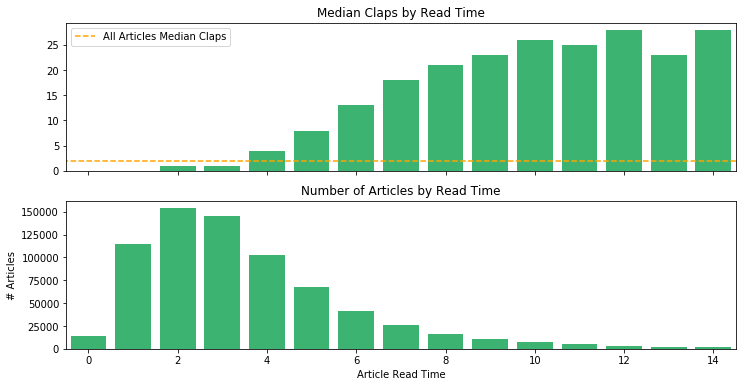

In [4]:
avs=[]
medians=[]
readts=[]
entries = []
for x in range(15):
    medians.append(medium[medium.Reading_Time==x].Claps.quantile(q=0.5))
    readts.append(x)
    entries.append(medium[medium.Reading_Time==x].shape[0])
    
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax1.bar(readts, medians,color = "mediumseagreen")
ax1.hlines(medium.Claps.quantile(q=0.5),-2,15,color="orange",
           linestyle="dashed",
           label="All Articles Median Claps")
ax1.set_title("Median Claps by Read Time")
plt.ylabel("Median Claps")
ax1.legend()
plt.xlabel("Article Read_Time")

ax2.bar(readts,entries, color="mediumseagreen")
ax2.set_title("Number of Articles by Read Time")
plt.ylabel("# Articles")
plt.xlabel("Article Read Time")
plt.xlim(-0.5,14.5)
plt.show()

In [5]:
#HERE WE DELETE THE ENTRIES IN THE RESTRICTEDMEDIUM DATAFRAME
medium_noShorts = restrictMedium[restrictMedium.Reading_Time>=2]
print("Total articles removed: ", restrictMedium.shape[0]-medium_noShorts.shape[0])
print("Percent of all articles removed: ", round(100-(medium_noShorts.shape[0]*100/restrictMedium.shape[0]),1), "%")
restrictMedium = medium_noShorts

Total articles removed:  128807
Percent of all articles removed:  17.9 %


<hr>
## Removing Authors with Only One Post
We scraped data from over a year of Medium archive pages Aug-1-2017 to Aug-1-2018. If an author only writes one post in a year they aren't a consistent writer.


### 18% of all articles will be the first (and last) post written by a Medium Author.

In [6]:
#Author counts
auth_counts = medium.Author.value_counts()
#authors with one post
OTPosters = auth_counts[auth_counts==1].index.values
#All articles from one-time-posters
OTP = medium[medium.Author.isin(OTPosters)]
print(round(auth_counts[auth_counts==1].sum()*100/auth_counts.sum(),1),"% percent of articles are attributed to single-post authors." )

18.2 % percent of articles are attributed to single-post authors.


### One-time-posters receive fewer claps. 

We see below that the population of articles from one time posters accounts for a lot of the low-performing articles in our dataset.

In [7]:
print("Entire Population Median article claps:",medium.Claps.mean())
print("One-Time-Posters Median article claps:",OTP.Claps.mean())

Entire Population Median article claps: 128.34442142136447
One-Time-Posters Median article claps: 73.80801851598069


### 57% of Medium authors from 8/2017-8/2018 wrote one post then stopped writing.

In [8]:
print(round(OTPosters.shape[0]*100/auth_counts.shape[0],1), "% percent of authors are one-time posters.")

57.0 % percent of authors are one-time posters.


In [9]:
#HERE WE DELETE THE ENTRIES IN THE RESTRICTEDMEDIUM DATAFRAME
#Author counts
auth_counts = restrictMedium.Author.value_counts()
#authors with one post
OTPosters = auth_counts[auth_counts==1].index.values
no_OTP = restrictMedium[~restrictMedium.Author.isin(OTPosters)]
print("Total articles removed: ", restrictMedium.shape[0]-no_OTP.shape[0])
print("Percent of all articles removed: ", round(100-(no_OTP.shape[0]*100/restrictMedium.shape[0]),1), "%")
restrictMedium = no_OTP

Total articles removed:  118348
Percent of all articles removed:  20.0 %


----------------------------------------------------------------------------------------------------------------------
## Removing Inconsistent Authors
To make a metric for consistent Medium authors, we will need to remove all posts written by inconsistent writers. Inconsistent authors write less than one article a month.

In [10]:
import datetime

#combines day, month, and year into one datetime object column
medium["Date"] = medium.apply(lambda row: datetime.date(row["Year"], row["Month"], row["Day"]),axis=1)

#creates a subdataframe
auths_dates =  medium.loc[:,["Author","Year","Month", "Date"]]

#creates a count column that we can sum during groupby op to get total articles
auths_dates["Count"]=1

### Caveat 
MonthArticleRatio =  Months an author has been on Medium - Number of posts by author

Though this will miss removing some authors that posted alot at one time, it will do the job that we need it to. Next we will remove all authors with a MARatio < 0, which <b>will remove all authors whose Total Articles < Months on Medium.</b>
    
Notice that this script would not have removed one-time-posters as Months on Medium = Total Articles.

### 86% of authors write an article every month they have been on Medium.

In [11]:
grouped_auth = auths_dates.groupby("Author")
MonthArticleRatio = grouped_auth.apply(lambda x: x.Count.sum()-round((x.Date.max()-x.Date.min()).days/30,1))
print("Percentage of authors that are consistent: ",round(MonthArticleRatio[MonthArticleRatio>=0].shape[0]*100/MonthArticleRatio.shape[0],1), "%")
consistentAuthors = MonthArticleRatio[MonthArticleRatio>=0].index

Percentage of authors that are consistent:  86.4 %


In [12]:
#HERE WE DELETE THE ENTRIES IN THE RESTRICTEDMEDIUM DATAFRAME
#combines day, month, and year into one datetime object column
restrictMedium["Date"] = restrictMedium.apply(lambda row: datetime.date(row["Year"], row["Month"], row["Day"]),axis=1)
#creates a subdataframe
auths_dates =  restrictMedium.loc[:,["Author","Year","Month", "Date"]]
#creates a count column that we can sum during groupby op to get total articles
auths_dates["Count"]=1
grouped_auth = auths_dates.groupby("Author")
MonthArticleRatio = grouped_auth.apply(lambda x: x.Count.sum()-round((x.Date.max()-x.Date.min()).days/30,1))
consistentAuthors = MonthArticleRatio[MonthArticleRatio>=0].index
mediumConsistent = restrictMedium[restrictMedium.Author.isin(consistentAuthors)]
print("Total articles removed: ", restrictMedium.shape[0]-mediumConsistent.shape[0])
print("Percent of all articles removed: ", round(100-(mediumConsistent.shape[0]*100/restrictMedium.shape[0]),1), "%")
restrictMedium = mediumConsistent

C:\Users\Harrison\Anaconda3\envs\py36\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Total articles removed:  98131
Percent of all articles removed:  20.7 %


# Analyzing the Restricted Data
Now we have two dataframes, "medium" which consists of all Medium articles w/ no deletions, and the "restrictMedium" dataframe which <b>removed short articles, one-time-posters, and inconsistent authors</b>. 


Before restrictions: 720k articles, 230k authors, 30k publications

<b>After restrictions: 493k articles (-32%), 175k authors(-24%), 23k publications(-23%)</b>



In [13]:
print("Number of Articles: ", restrictMedium.shape[0])
print("Number of Authors: ", restrictMedium.Author.value_counts().shape[0])
print("Number of Publications: ", restrictMedium.Publication.value_counts().shape[0])
print("Number of Tags: ", restrictMedium.columns[12:-1].shape[0])

Number of Articles:  375247
Number of Authors:  56970
Number of Publications:  13073
Number of Tags:  36


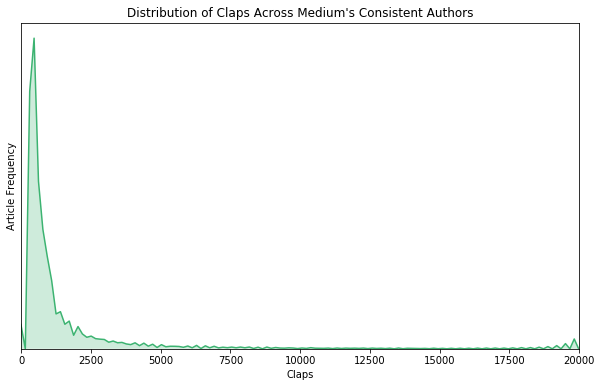

In [14]:
#KDE plot, shade below curve, clip arg includes values of 0 to 20000
plt.figure(figsize=(10,6))
sns.kdeplot(restrictMedium.Claps, shade=True, legend=False, clip=[-1,20000],color = "mediumseagreen" )
plt.title("Distribution of Claps Across Medium's Consistent Authors")
plt.ylabel("Article Frequency")
plt.xlabel("Claps")
plt.yticks([])
plt.xlim(0,20000)
plt.show()

In [15]:
print("Percentiles of Number of Claps")
print("MEDIAN 50th :", restrictMedium.Claps.quantile(q=0.5))
print("90th :", restrictMedium.Claps.quantile(q=0.90))
print("99th :", round(restrictMedium.Claps.quantile(q=0.99),1))
print("99.9th :", round(restrictMedium.Claps.quantile(q=0.999),1))

Percentiles of Number of Claps
MEDIAN 50th : 3.0
90th : 249.0
99th : 2754.0
99.9th : 15275.4


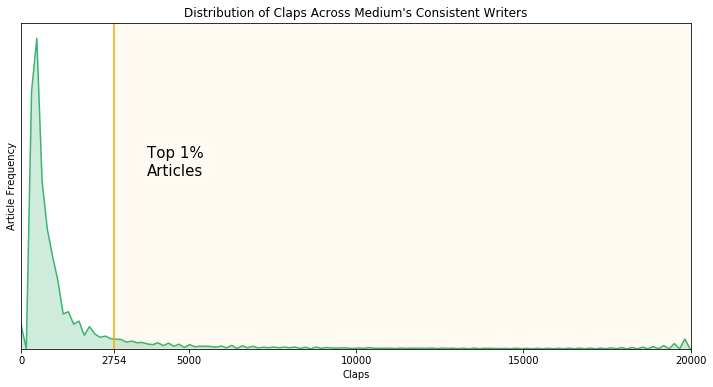

In [16]:
nine2 = restrictMedium.Claps.quantile(q=0.99)

plt.figure(figsize=(12,6))
sns.kdeplot(restrictMedium.Claps, shade=True, legend=False,cut=3,clip=[-5,20000], color="mediumseagreen")
plt.title("Distribution of Claps Across Medium's Consistent Writers")
plt.ylabel("Article Frequency")
plt.xlabel("Claps")
plt.xlim(-5,20000)
plt.xticks([0,nine2,5000,10000,15000,20000])
plt.yticks([])


plt.axvline(x=nine2, color="orange")
plt.text(nine2+1000,0.0000700,"Top 1%\nArticles", fontsize=15)
plt.axvspan(nine2, 200000, alpha=0.05, color='orange')
plt.show()

## 0.1% of articles by consistent authors receive 15k claps.


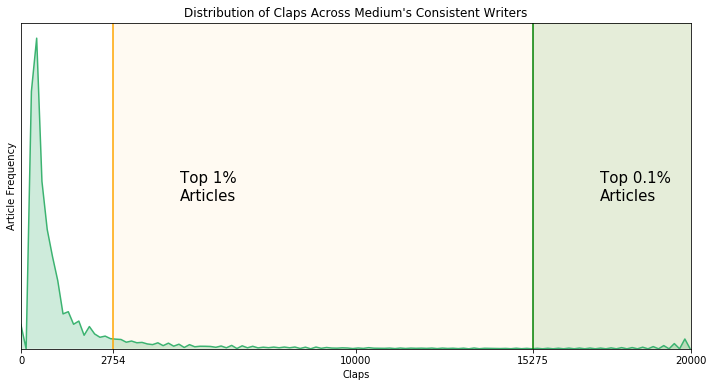

In [17]:
nine2 = restrictMedium.Claps.quantile(q=0.99)
nine3 = restrictMedium.Claps.quantile(q=0.999)

bins = [0,5,10, 25, 50, 125, 250, 500, 1000, 2500, 5000, 7500, 10000, 20000, 40000, 250000]


plt.figure(figsize=(12,6))
sns.kdeplot(restrictMedium.Claps, shade=True, legend=False, clip=[-1,20000], color="mediumseagreen")

plt.title("Distribution of Claps Across Medium's Consistent Writers")
plt.ylabel("Article Frequency")
plt.xlabel("Claps")
plt.xlim(0,20000)
plt.xticks([0,nine2,10000,nine3,20000])
plt.yticks([])

plt.axvline(x=nine2, color="orange")
plt.axvspan(nine2, 50000, alpha=0.05, color='orange')

plt.axvline(x=nine3, color="green")
plt.axvspan(nine3, 50000, alpha=0.1, color='green')

plt.text(nine2+2000,0.0000600,"Top 1%\nArticles", fontsize=15)
plt.text(nine3+2000,0.0000600,"Top 0.1%\nArticles", fontsize=15)

plt.show()